<a href="https://colab.research.google.com/github/debisree/SHAP_NB/blob/main/Boston_SHAP_Lab_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# SHAP Lab (Colab): Interpreting a Boston Housing Regression Model

This notebook is designed to run on **Google Colab** and accompanies a tutorial on **SHAP (SHapley Additive exPlanations)** and model interpretability.

The lab will:

1. Install and import required libraries.
2. Load the **Boston Housing** dataset from a CSV file.
3. Train a tree-based regression model to predict house prices (`MEDV`).
4. Use **SHAP** to decompose predictions into feature-level contributions.
5. Visualize and interpret the key SHAP plots:
   - Summary (beeswarm) plot
   - Bar plot (mean |SHAP|)
   - Dependence plot
   - Waterfall plot (single prediction)
   - Decision plot
6. Derive a quantitative feature ranking from SHAP values.
7. Discuss pitfalls and best practices when using SHAP.


## 0. Environment Setup (for Colab)

In [1]:

# If running on Google Colab, install shap (uncomment if needed)
!pip install shap --quiet



## 1. Background: Shapley Values and SHAP

SHAP is based on **Shapley values** from cooperative game theory. In such games, several players cooperate to achieve a joint payoff, and the Shapley value provides a *fair* allocation of this payoff among them.

For a model \( f \) with feature set \( N = \{1, 2, \dots, n\} \), the Shapley value for feature \( i \) is defined as:

\[
\phi_i = \sum_{S \subseteq N \setminus \{i\}}
\frac{|S|! (n - |S| - 1)!}{n!} \left[ f(S \cup \{i\}) - f(S) \right]
\]

Here, \(S\) ranges over all subsets of features that do not contain \(i\). The term \(f(S \cup \{i\}) - f(S)\) is the *marginal contribution* of feature \(i\) when added to subset \(S\).

Key axioms satisfied by Shapley values:

- **Efficiency**: Contributions sum to the total prediction (minus a baseline).
- **Symmetry**: Identical features receive equal contributions.
- **Dummy**: Irrelevant features receive zero contribution.
- **Additivity**: Contributions are additive across models.

SHAP adapts these Shapley values to machine learning models and provides efficient algorithms and visualizations for interpretation.



## 2. Imports and Data Loading

This notebook assumes that the Boston Housing dataset is available as a CSV file with a column named `MEDV` for the target variable.

There are two common options in Colab:

- **Option A (Upload)**: Manually upload `HousingData.csv` using the Colab file upload dialog.
- **Option B (GitHub URL)**: Load directly from a raw GitHub URL if the CSV is stored in a public repository.


In [4]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

import shap



# ----- Option A: Upload file in Colab -----
# from google.colab import files
# uploaded = files.upload()  # then select HousingData.csv
# df = pd.read_csv("HousingData.csv")

#----- Option B: Load from GitHub (edit URL as needed) -----
raw_url = "https://raw.githubusercontent.com/debisree/SHAP_NB/main/HousingData.csv"
df = pd.read_csv(raw_url)

# ----- Default: Assume CSV is already in the working directory -----
#df = pd.read_csv("HousingData.csv")

df.head()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2



## 3. Quick Exploratory Check

The following cells provide a minimal structural overview of the dataset. A full exploratory data analysis (EDA) is intentionally omitted, as the focus here is on SHAP-based interpretability rather than exhaustive data analysis.


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     486 non-null    float64
 1   ZN       486 non-null    float64
 2   INDUS    486 non-null    float64
 3   CHAS     486 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      486 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    486 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CRIM,486.0,3.611874,8.720192,0.00632,0.081900,0.253715,3.560263,88.9762
ZN,486.0,11.211934,23.388876,0.00000,0.000000,0.000000,12.500000,100.0000
INDUS,486.0,11.083992,6.835896,0.46000,5.190000,9.690000,18.100000,27.7400
CHAS,486.0,0.069959,0.255340,0.00000,0.000000,0.000000,0.000000,1.0000
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.538000,0.624000,0.8710
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.208500,6.623500,8.7800
AGE,486.0,68.518519,27.999513,2.90000,45.175000,76.800000,93.975000,100.0000
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.207450,5.188425,12.1265
RAD,506.0,9.549407,8.707259,1.00000,4.000000,5.000000,24.000000,24.0000
TAX,506.0,408.237154,168.537116,187.00000,279.000000,330.000000,666.000000,711.0000



## 4. Model Training

### 4.1 Target and Feature Definition

The variable `MEDV` is used as the regression target, and all remaining columns are treated as predictors.


In [7]:

target_col = "MEDV"
X = df.drop(columns=[target_col])
y = df[target_col]



### 4.2 Train-Test Split and Model Fit

This demonstration focuses exclusively on SHAP and model explainability. To maintain clarity, standard machine learning workflow components—such as extensive data cleaning, preprocessing, exploratory data analysis (EDA), feature engineering, or hyperparameter tuning—are intentionally omitted. The objective is not to optimize predictive performance, but to create a functional model whose behavior can be interpreted through SHAP.

A Random Forest regressor is used to model `MEDV`.


In [11]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("R^2 on test set:", r2)
print("RMSE on test set:", rmse)


R^2 on test set: 0.8795414426143554
RMSE on test set: 2.972151026970901



## 5. Computing SHAP Values

Once the model is trained, each combination of feature values in the dataset produces a corresponding predicted response. However, the model does not inherently reveal how individual features contribute to these predictions. SHAP provides a principled mechanism to decompose each prediction into additive contributions from every feature, allowing the model's internal reasoning to be examined directly.

To compute SHAP values efficiently for tree-based models such as Random Forests and Gradient Boosting, SHAP offers the **TreeExplainer**, which leverages model structure to provide fast, exact or near-exact Shapley value estimates.


In [12]:

explainer = shap.TreeExplainer(model, X_train)
shap_values = explainer(X_test)

shap_values.values.shape  # (n_samples, n_features)


(102, 13)


For models not based on decision trees—such as linear models, neural networks, or arbitrary black-box estimators—SHAP provides alternative explainers:

- **KernelExplainer**: model-agnostic, based on perturbation sampling; applicable to any model but typically more computationally expensive.
- **DeepExplainer**: optimized for certain neural network architectures.
- **LinearExplainer**: efficient for linear and generalized linear models.

`TreeExplainer` is used here because the underlying Random Forest supports efficient computation of Shapley values while preserving the theoretical properties of the attribution.



## 6. Global Interpretability: SHAP Summary Plot

The SHAP summary (beeswarm) plot shows:

- Global feature importance (vertical order),
- The direction and magnitude of feature impact (horizontal axis),
- The distribution of SHAP values across all samples (point cloud).

Each point corresponds to a single sample; color encodes whether the feature value is relatively low (blue) or high (red).


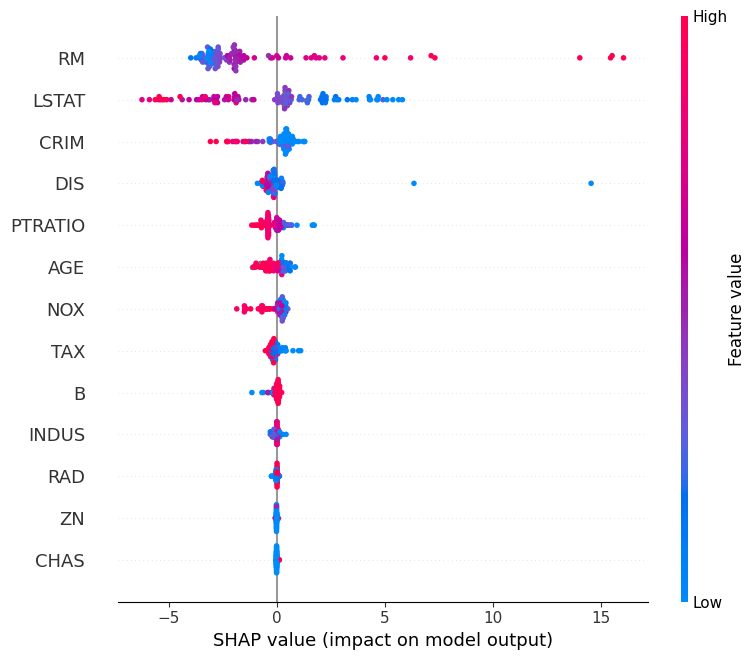

In [13]:

shap.summary_plot(shap_values, X_test)



## 7. Global Feature Ranking: SHAP Bar Plot (Mean |SHAP|)

The bar plot aggregates the mean absolute SHAP value for each feature, providing a principled ranking of global feature importance.


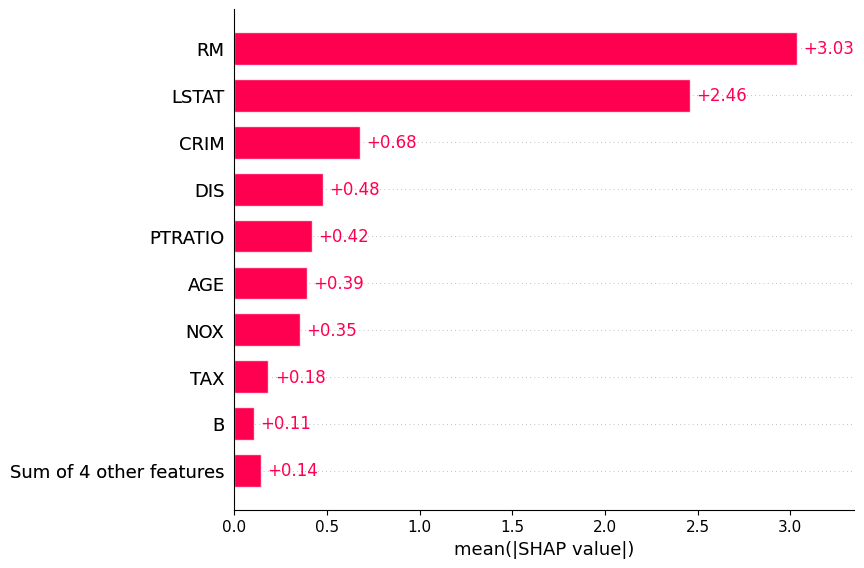

In [14]:

shap.plots.bar(shap_values)



## 8. Feature Effects and Interactions: SHAP Dependence Plot

The dependence plot visualizes how a feature's value relates to its SHAP value, revealing both non-linear effects and potential interactions with other features. A common choice in the Boston Housing dataset is `LSTAT` (percentage of lower-status population).


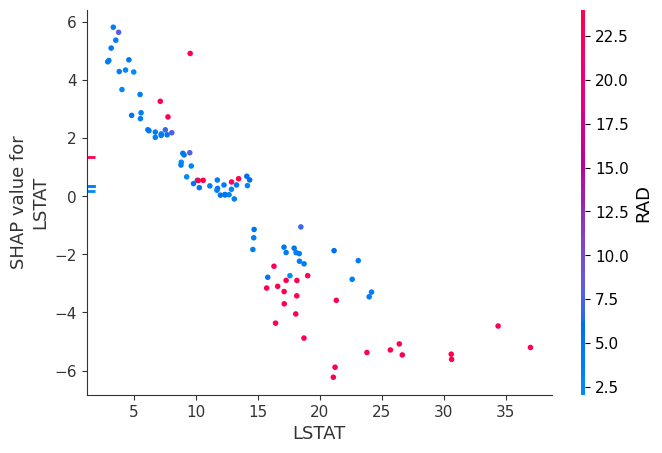

In [15]:

feature_name = "LSTAT" if "LSTAT" in X_test.columns else X_test.columns[0]
shap.dependence_plot(feature_name, shap_values.values, X_test)



## 9. Local Explanation: SHAP Waterfall Plot for a Single Prediction

For a selected test sample, the waterfall plot decomposes the prediction into additive contributions from each feature, starting from the baseline (the expected prediction) and ending at the model's output for that sample.


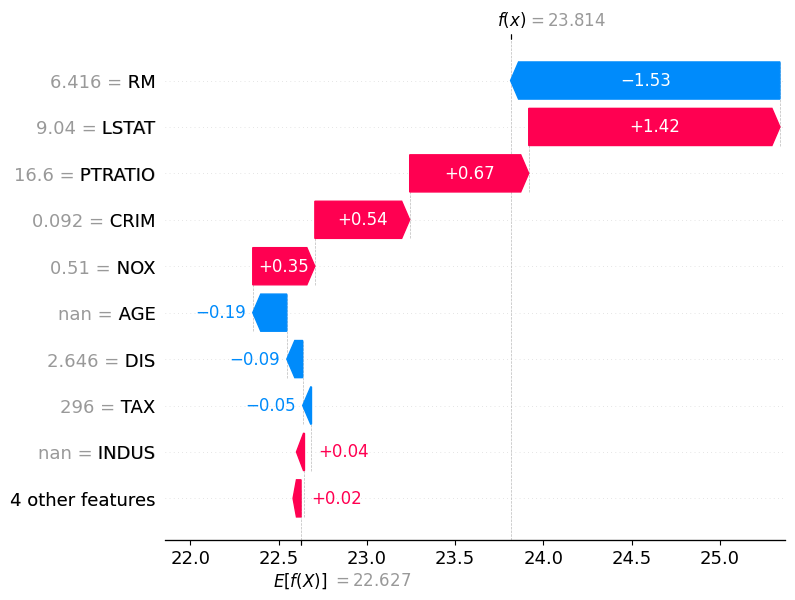

In [16]:

idx = 0  # index of the sample to explain
shap.plots.waterfall(shap_values[idx])



## 10. Local Explanations Across Multiple Samples: SHAP Decision Plot

The decision plot shows how feature contributions accumulate from the baseline to the final predictions for several samples simultaneously. This is useful for comparing how the model behaves across different instances.


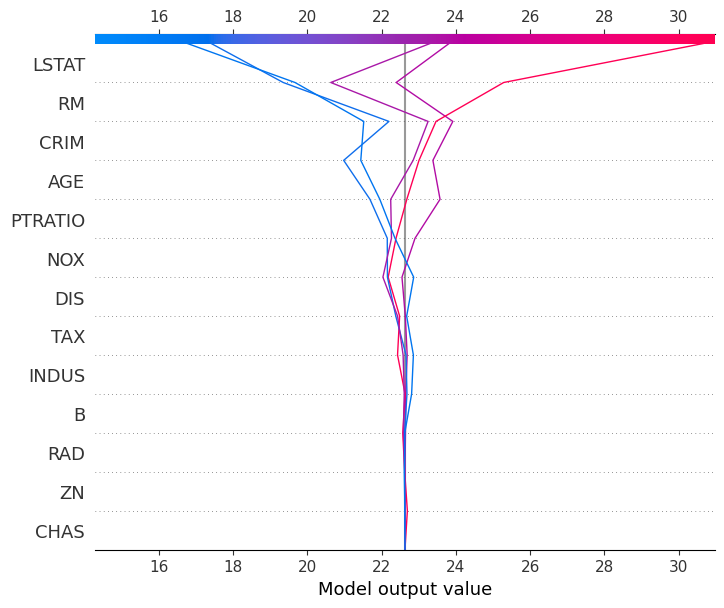

In [17]:

shap.decision_plot(
    explainer.expected_value,
    shap_values.values[:5],
    X_test.iloc[:5]
)



## 11. Quantitative Feature Importance from Mean |SHAP|

To derive a numeric feature ranking, the mean absolute SHAP value for each feature is computed and sorted in descending order.


In [18]:

mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
importance_df = pd.DataFrame({
    "feature": X_test.columns,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False)

importance_df


,feature,mean_abs_shap
5,RM,3.033503
12,LSTAT,2.457998
0,CRIM,0.679046
7,DIS,0.477448
10,PTRATIO,0.419302
6,AGE,0.390528
4,NOX,0.354024
9,TAX,0.184023
11,B,0.105394
2,INDUS,0.089173



## 12. Pitfalls and Best Practices

Some considerations when working with SHAP:

- **Feature Correlation**: Strongly correlated features may share importance in ways that complicate interpretation. Consider clustering or combining such features.
- **Computational Cost**: Although `TreeExplainer` is efficient for tree-based models, SHAP can still be expensive for very large datasets. Sampling may be necessary.
- **Causality vs. Association**: SHAP explains model behavior, not underlying causal mechanisms in the data.
- **Additivity Assumption**: SHAP assumes additive contributions; highly non-linear interactions should be examined carefully using interaction and dependence plots.
